In [46]:
%matplotlib inline

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from tensorflow import keras
from tensorflow.keras import regularizers
from keras import backend as K

import tensorflow_datasets as tfds 

In [164]:
class Dataset:
    '''
    This class will facilitate the creation of a few-shot dataset
    from the Omniglot dataset that can be sampled from quickly while also
    allowing to create new labels at the same time.
    
    Adopted from https://keras.io/examples/vision/reptile/
    '''
    
    def __init__(self, training):
        # Download the tfrecord files containing the omniglot data and convert to a dataset
        split = "train" if training else "test"
        ds = tfds.load('omniglot', split=split, as_supervised=True)
        # Iterate over the dataset to get each individual image and its class,
        # and put that data into a dictionary.
        self.data = {}
        
        def extraction(image, label):
            # This function will shrink the Omniglot images to the desired size,
            # scale pixel values and convert the RGB image to grayscale
            image = tf.image.convert_image_dtype(image, tf.float32)
            image = tf.image.rgb_to_grayscale(image)
            image = tf.image.resize(image, [105, 105])
            # image /= 255.
            return image, label
        
        for image, label in ds.map(extraction):
            image = image.numpy()
            label = str(label.numpy())
            if label not in self.data:
                self.data[label] = []
            self.data[label].append(image)
            self.labels = list(self.data.keys())

In [165]:
train = Dataset(training=True)
test = Dataset(training=False)

In [166]:
def plot_biplet(triplet):
    plt.figure(figsize=(6,2))
    for i in range(0, 2):
        plt.subplot(1,2,i+1)
        plt.imshow(np.reshape(triplet[i], (105,105,1)), cmap='binary')
        plt.xticks([])
        plt.yticks([])
    plt.show()

In [167]:
example = []
for key, value in train.data.items():
    for i in range(2):
        example.append(value[i])
        print(key)
    break

617
617


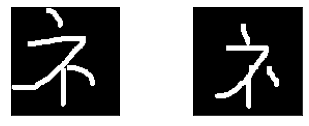

In [168]:
plot_biplet(example)

In [59]:
def create_cnn_model(input_shape, num_classes):
    tf.keras.backend.clear_session()
    cnn_model = keras.models.Sequential()
    
    # add layer
    cnn_model.add(keras.layers.Conv2D(32, kernel_size=(3,3), activation="relu", input_shape=input_shape))
    cnn_model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
    cnn_model.add(keras.layers.Conv2D(64, (3,3), activation="relu"))
    cnn_model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
    cnn_model.add(keras.layers.Flatten())
    cnn_model.add(keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l1(0.01)))
    cnn_model.add(keras.layers.Dropout(0.25))
    cnn_model.add(keras.layers.Dense(num_classes, activation='softmax'))
    
    return cnn_model

In [63]:
input_shape = (28, 28, 1)
num_classes = len(train.labels)

cnn_model = create_cnn_model(input_shape, num_classes)
cnn_model.summary()

Model: &quot;sequential&quot;
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               204928    
_________________________________________________________________
dropout (Dropout)            (None, 128)      

In [99]:
# create training+test positive and negative pairs
def create_pairs(x, num_classes):
    pairs = []
    labels = []
    n = min([len(x.data[i]) for i in num_classes]) - 1
    for index, value in enumerate(num_classes):
        for i in range(n):
            z1, z2 = x.data[value][i], x.data[value][i+1]
            pairs += [[z1, z2]]
            inc = random.randrange(1, len(num_classes))
            index_n = (index + inc) % len(num_classes)
            index_v = random.randint(0, n)
            z3 = x.data[num_classes[index_n]][index_v]
            pairs += [[z1, z3]]
            labels += [1., 0.]
    return np.array(pairs), np.array(labels)

In [100]:
tr_x, tr_y = create_pairs(train, train.labels)
print(tr_x.shape)
print(tr_y.shape)

(36632, 2, 28, 28, 1)
(36632,)


In [101]:
te_x, te_y = create_pairs(test, test.labels)
print(te_x.shape)
print(te_y.shape)

(25042, 2, 28, 28, 1)
(25042,)


In [107]:
np.savez('omniglot.npz', tr_x=tr_x, tr_y=tr_y, te_x=te_x, te_y=te_y)

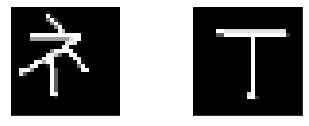

In [102]:
plot_biplet(tr_x[5])

In [39]:
# adapted from https://github.com/keras-team/keras/blob/master/examples/mnist_siamese.py

def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)


def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)

In [103]:
input_a = tf.keras.layers.Input(shape=input_shape)
input_b = tf.keras.layers.Input(shape=input_shape)

In [104]:
processed_a = cnn_model(input_a)
processed_b = cnn_model(input_b)

In [105]:
distance = tf.keras.layers.Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([processed_a, processed_b])

model = tf.keras.models.Model([input_a, input_b], distance)

In [121]:
model.summary()

Model: &quot;functional_3&quot;
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 964)          348100      input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 1)            0           sequential[2

In [106]:
# train
epochs=20
rms = tf.keras.optimizers.RMSprop()
model.compile(loss=contrastive_loss, optimizer=rms, metrics=['accuracy'])
history = model.fit([tr_x[:, 0], tr_x[:, 1]], tr_y,
          batch_size=128,
          epochs=epochs,
          validation_data=([te_x[:, 0], te_x[:, 1]], te_y))

Epoch 1/20
287/287 [==============================] - 80s 278ms/step - loss: 0.4121 - accuracy: 0.4984 - val_loss: 0.4946 - val_accuracy: 0.5000
Epoch 2/20
287/287 [==============================] - 67s 233ms/step - loss: 0.2883 - accuracy: 0.5007 - val_loss: 0.5047 - val_accuracy: 0.5000
Epoch 3/20
287/287 [==============================] - 65s 226ms/step - loss: 0.2818 - accuracy: 0.5009 - val_loss: 0.5036 - val_accuracy: 0.5000
Epoch 4/20
287/287 [==============================] - 65s 225ms/step - loss: 0.2760 - accuracy: 0.4980 - val_loss: 0.5019 - val_accuracy: 0.5000
Epoch 5/20
287/287 [==============================] - 63s 218ms/step - loss: 0.2738 - accuracy: 0.4999 - val_loss: 0.5005 - val_accuracy: 0.5000
Epoch 6/20
287/287 [==============================] - 60s 210ms/step - loss: 0.2719 - accuracy: 0.5004 - val_loss: 0.5018 - val_accuracy: 0.5000
Epoch 7/20
287/287 [==============================] - 59s 205ms/step - loss: 0.2708 - accuracy: 0.4998 - val_loss: 0.4995 - val_ac

&lt;tensorflow.python.keras.callbacks.History at 0x14b621050&gt;

In [108]:
len(train.labels)

964

In [109]:
len(test.labels)

659

In [114]:
new_model = tf.keras.models.load_model('IFN680_A2/my_model/', compile=False)

In [116]:
new_model.compile(optimizer=rms, loss=contrastive_loss, metrics=['accuracy'])

In [117]:
new_model.summary()

Model: &quot;functional_1&quot;
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 964)          348100      input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0           sequential[0

In [119]:
loss, acc = new_model.evaluate(te_x, te_y, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100*acc))


ValueError: in user code:

    /Users/d1w1rnna/Documents/work/IFN680/IFN680_J/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1224 test_function  *
        return step_function(self, iterator)
    /Users/d1w1rnna/Documents/work/IFN680/IFN680_J/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1215 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /Users/d1w1rnna/Documents/work/IFN680/IFN680_J/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /Users/d1w1rnna/Documents/work/IFN680/IFN680_J/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /Users/d1w1rnna/Documents/work/IFN680/IFN680_J/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    /Users/d1w1rnna/Documents/work/IFN680/IFN680_J/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1208 run_step  **
        outputs = model.test_step(data)
    /Users/d1w1rnna/Documents/work/IFN680/IFN680_J/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1174 test_step
        y_pred = self(x, training=False)
    /Users/d1w1rnna/Documents/work/IFN680/IFN680_J/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:985 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /Users/d1w1rnna/Documents/work/IFN680/IFN680_J/lib/python3.7/site-packages/tensorflow/python/keras/engine/functional.py:386 call
        inputs, training=training, mask=mask)
    /Users/d1w1rnna/Documents/work/IFN680/IFN680_J/lib/python3.7/site-packages/tensorflow/python/keras/engine/functional.py:508 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    /Users/d1w1rnna/Documents/work/IFN680/IFN680_J/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:976 __call__
        self.name)
    /Users/d1w1rnna/Documents/work/IFN680/IFN680_J/lib/python3.7/site-packages/tensorflow/python/keras/engine/input_spec.py:216 assert_input_compatibility
        &#39; but received input with shape &#39; + str(shape))

    ValueError: Input 0 of layer sequential is incompatible with the layer: expected axis -1 of input shape to have value 1 but received input with shape [None, 2, 28, 28]


In [126]:
for key, value in test.data.items():
    print(type(key))
    print(type(value))
    break

&lt;class &#39;str&#39;&gt;
&lt;class &#39;list&#39;&gt;


In [142]:
test_image = []
test_label = []
for key, value in test.data.items():
    for ele in value:
        test_image.append(ele)
        test_label.append(key)
test_image = np.array(test_image)
test_label = np.array(test_label)

In [143]:
test_image.shape

(13180, 28, 28, 1)

In [144]:
loss, acc = new_model.evaluate(test_image, test_label, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100*acc))

AssertionError: in user code:

    /Users/d1w1rnna/Documents/work/IFN680/IFN680_J/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1224 test_function  *
        return step_function(self, iterator)
    /Users/d1w1rnna/Documents/work/IFN680/IFN680_J/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1215 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /Users/d1w1rnna/Documents/work/IFN680/IFN680_J/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /Users/d1w1rnna/Documents/work/IFN680/IFN680_J/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /Users/d1w1rnna/Documents/work/IFN680/IFN680_J/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    /Users/d1w1rnna/Documents/work/IFN680/IFN680_J/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1208 run_step  **
        outputs = model.test_step(data)
    /Users/d1w1rnna/Documents/work/IFN680/IFN680_J/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1174 test_step
        y_pred = self(x, training=False)
    /Users/d1w1rnna/Documents/work/IFN680/IFN680_J/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:985 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /Users/d1w1rnna/Documents/work/IFN680/IFN680_J/lib/python3.7/site-packages/tensorflow/python/keras/engine/functional.py:386 call
        inputs, training=training, mask=mask)
    /Users/d1w1rnna/Documents/work/IFN680/IFN680_J/lib/python3.7/site-packages/tensorflow/python/keras/engine/functional.py:517 _run_internal_graph
        assert x_id in tensor_dict, &#39;Could not compute output &#39; + str(x)

    AssertionError: Could not compute output Tensor(&quot;lambda/Sqrt_3:0&quot;, shape=(None, 1), dtype=float32)


In [147]:
pred = new_model.predict([te_x[:, 0], te_x[:, 1]])

In [148]:
def compute_accuracy(y_true, y_pred):
    '''
    For evaluating the prediction accuracy of the model.
    Taken from https://github.com/keras-team/keras/blob/master/examples/mnist_siamese.py
    -returns:
        Accuracy
    '''

    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)

def accuracy(y_true, y_pred):
    '''
    Computes classification accuracy with a fixed threshold on distances.
    Taken from https://github.com/keras-team/keras/blob/master/examples/mnist_siamese.py
    '''

    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))

In [150]:
print('* Accuracy on training set: %0.2f%%' % (100 * compute_accuracy(te_y, pred)))

* Accuracy on training set: 50.00%


In [151]:
pred = new_model.predict([tr_x[:, 0], tr_x[:, 1]])
print('* Accuracy on training set: %0.2f%%' % (100 * compute_accuracy(tr_y, pred)))

* Accuracy on training set: 50.00%


In [152]:
train_labels_set = set(train.labels)
test_labels_set = set(test.labels)

In [153]:
labels_set = train_labels_set.union(test_labels_set)

In [154]:
len(labels_set)

1623

In [155]:
print(len(train_labels_set))
print(len(test_labels_set))

964
659
